# 確率ロボティクス課題 2019

適当なタイルワールドを作って、そのなかでのエージェントの動きを強化学習のアルゴリズムを使って生成してください。Jupyter Notebookにコードと動作結果（図）を記録してGitHubにアップロードのこと。締切は1月31日

## やったことの要約

1. https://github.com/ryuichiueda/probrobo2017/blob/master/09.ipynb を参考にした
2. 変更点
    1. 3x3マスを5x5マスに拡大
    2. ゴール位置を変更した
        - (x: 3, y: 3)の位置にした
    3. 障害物を置いた
        - (x: 3, y: 2)の位置に
        - 落とし穴のつもりで障害物を設置
        - 穴に落ちたらペナルティ: 10.0
        - 落ちた時点でエピソード終了
    4. 報酬の与え方を変更
        - 1 stepの行動でペナルティ: 1
        - ゴールしたらペナルティ: 0
        - 穴に落ちたらペナルティ: 10

----

https://github.com/ryuichiueda/probrobo2017/blob/master/09.ipynb の`draw`関数の

```python
values = [[states[i][j].Q[states[i][j].best_action] for j in range(size)] for i in range(size)]
```

で`i, j`が逆です

In [43]:
class Agent:
    def __init__(self):
        self.actions = ["up", "down", "left", "right"]
        self.pos = (0, 0)

agent = Agent()

In [44]:
size = 5

class State:
    def __init__(self, actions):
        self.Q = {}
        for a in actions:
            self.Q[a] = 0.0
        self.best_action = "up"
        self.goal = False
        self.obstacle = False
    
    def get_best_Q(self):
        if self.obstacle:
            return 3.0
        elif self.goal:
            return 0.0
        else:
            return self.Q[self.best_action]

    def set_goal(self, actions):
        for a in actions:
            self.Q[a] = 0.0
        self.goal = True
    
    def set_obstacle(self, actions):
        for a in actions:
            self.Q[a] = 0.0
        self.obstacle = True

states = [[State(agent.actions) for i in range(size)] for j in range(size)]
states[3][3].set_goal(agent.actions)
states[3][2].set_obstacle(agent.actions)

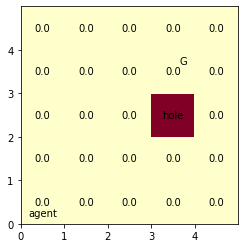

In [45]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def draw(mark_pos):
    fig, ax = plt.subplots()
    values = [[states[j][i].get_best_Q() for j in range(size)] for i in range(size)]
    mp = ax.pcolor(values, cmap=plt.cm.YlOrRd, vmin=0, vmax=3)
    ax.set_aspect(1)
    ax.set_xticks(range(size), minor=False)
    ax.set_yticks(range(size), minor=False)
    
    for x in range(len(values)):
        for y in range(len(values[0])):
            s = states[x][y]
            if states[x][y].obstacle:
                plt.text(x+0.5, y+0.5, "hole", ha='center', va='center', size=10)
                continue
            plt.text(x+0.5, y+0.5, int(1000 * s.Q[s.best_action]) / 1000, ha='center', va='center', size=10)
            if states[x][y].goal:
                plt.text(x+0.75, y+0.75, "G", ha='center', va='center', size=10)
    plt.text(agent.pos[0]+0.5, agent.pos[1] + 0.25, "agent", ha='center', va='center', size=10)
    if mark_pos == "all":
        for x in range(size):
            for y in range(size):
                if states[x][y].goal or states[x][y].obstacle:
                    continue
                plt.text(x+0.5, y+0.25, states[x][y].best_action, ha='center', va='center', size=10)
    elif mark_pos != None:
        s = states[mark_pos[0]][mark_pos[1]]
        plt.text(mark_pos[0]+0.5, mark_pos[1]+0.25, s.best_action, ha='center', va='center', size=10)
    plt.show()
    fig.clear()
    
draw(None)

In [46]:
import random

def state_transition(s_pos, a):
    if random.uniform(0, 1) < 0.1:
        return s_pos
    
    x, y = s_pos
    if a == "up":
        y += 1
    elif a == "down":
        y -= 1
    elif a == "right":
        x += 1
    elif a == "left":
        x -= 1

    x = min(max(x, 0), size-1)
    y = min(max(y, 0), size-1)
    
    return (x, y)

In [47]:
def e_greedy(s):
    if random.uniform(0, 1) < 0.1:
        return random.choice(agent.actions)
    else:
        best_s = None
        best_q = 1e10
        for a in s.Q:
            if best_q > s.Q[a]:
                best_q = s.Q[a]
                best_a = a
        s.best_action = best_a
        return best_a

s:(0, 0)　a:up s':(0, 1) a':right
----
s:(0, 1)　a:right s':(1, 1) a':up
----
s:(1, 1)　a:up s':(1, 2) a':up
----
s:(1, 2)　a:up s':(1, 3) a':right
----
s:(1, 3)　a:right s':(2, 3) a':up
----
s:(2, 3)　a:up s':(2, 4) a':up
----
s:(2, 4)　a:up s':(2, 4) a':up
----
s:(2, 4)　a:up s':(2, 4) a':left
----
s:(2, 4)　a:left s':(1, 4) a':up
----
s:(1, 4)　a:up s':(1, 4) a':up
----
s:(1, 4)　a:up s':(1, 4) a':down
----
s:(1, 4)　a:down s':(1, 4) a':down
----
s:(1, 4)　a:down s':(1, 3) a':up
----
s:(1, 3)　a:up s':(1, 3) a':up
----
s:(1, 3)　a:up s':(1, 4) a':left
----
s:(1, 4)　a:left s':(0, 4) a':up
----
s:(0, 4)　a:up s':(0, 4) a':up
----
s:(0, 4)　a:up s':(0, 4) a':down
----
s:(0, 4)　a:down s':(0, 3) a':up
----
s:(0, 3)　a:up s':(0, 4) a':right
----
s:(0, 4)　a:right s':(1, 4) a':right
----
s:(1, 4)　a:right s':(2, 4) a':down
----
s:(2, 4)　a:down s':(2, 3) a':down
----
s:(2, 3)　a:down s':(2, 2) a':up
----
s:(2, 2)　a:up s':(2, 3) a':left
----
s:(2, 3)　a:left s':(2, 3) a':left
----
s:(2, 3)　a:left s':(1, 3) a':dow

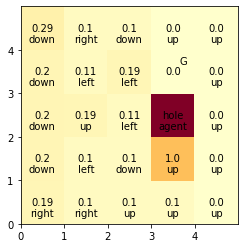

s:(1, 1)　a:right s':(1, 1) a':right
----
s:(1, 1)　a:right s':(2, 1) a':left
----
s:(2, 1)　a:left s':(1, 1) a':right
----
s:(1, 1)　a:right s':(2, 1) a':right
----
s:(2, 1)　a:right s':(3, 1) a':down
----
s:(3, 1)　a:down s':(3, 0) a':down
----
s:(3, 0)　a:down s':(3, 0) a':down
----
s:(3, 0)　a:down s':(3, 0) a':left
----
s:(3, 0)　a:left s':(3, 0) a':left
----
s:(3, 0)　a:left s':(3, 0) a':down
----
s:(3, 0)　a:down s':(3, 0) a':right
----
s:(3, 0)　a:right s':(4, 0) a':down
----
s:(4, 0)　a:down s':(4, 0) a':up
----
s:(4, 0)　a:up s':(4, 1) a':up
----
s:(4, 1)　a:up s':(4, 2) a':up
----
s:(4, 2)　a:up s':(4, 3) a':up
----
s:(4, 3)　a:up s':(4, 4) a':up
----
s:(4, 4)　a:up s':(4, 4) a':up
----
s:(4, 4)　a:up s':(4, 4) a':down
----
s:(4, 4)　a:down s':(4, 3) a':down
----
s:(4, 3)　a:down s':(4, 2) a':down
----
s:(4, 2)　a:down s':(4, 1) a':down
----
s:(4, 1)　a:down s':(4, 0) a':left
----
s:(4, 0)　a:left s':(3, 0) a':up
----
s:(3, 0)　a:up s':(3, 1) a':left
----
s:(3, 1)　a:left s':(2, 1) a':up
----
s:(2, 1

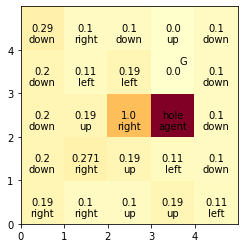

s:(2, 1)　a:down s':(2, 0) a':down
----
s:(2, 0)　a:down s':(2, 0) a':down
----
s:(2, 0)　a:down s':(2, 0) a':left
----
s:(2, 0)　a:left s':(1, 0) a':up
----
s:(1, 0)　a:up s':(1, 1) a':up
----
s:(1, 1)　a:up s':(1, 2) a':down
----
s:(1, 2)　a:down s':(1, 1) a':down
----
s:(1, 1)　a:down s':(1, 0) a':right
----
s:(1, 0)　a:right s':(2, 0) a':up
----
s:(2, 0)　a:up s':(2, 0) a':up
----
s:(2, 0)　a:up s':(2, 1) a':right
----
s:(2, 1)　a:right s':(3, 1) a':up
----
s:(3, 1)　a:up s':(3, 2) a':up
----


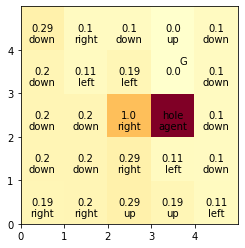

s:(4, 1)　a:left s':(3, 1) a':right
----
s:(3, 1)　a:right s':(4, 1) a':right
----
s:(4, 1)　a:right s':(4, 1) a':right
----
s:(4, 1)　a:right s':(4, 1) a':up
----
s:(4, 1)　a:up s':(4, 2) a':left
----
s:(4, 2)　a:left s':(3, 2) a':up
----


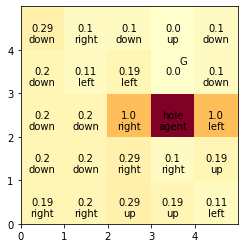

s:(4, 2)　a:right s':(4, 2) a':right
----
s:(4, 2)　a:right s':(4, 2) a':up
----
s:(4, 2)　a:up s':(4, 3) a':left
----
s:(4, 3)　a:left s':(3, 3) a':up
----


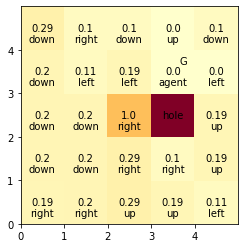

s:(4, 0)　a:right s':(4, 0) a':right
----
s:(4, 0)　a:right s':(4, 0) a':up
----
s:(4, 0)　a:up s':(4, 1) a':down
----
s:(4, 1)　a:down s':(4, 0) a':down
----
s:(4, 0)　a:down s':(4, 0) a':down
----
s:(4, 0)　a:down s':(4, 0) a':left
----
s:(4, 0)　a:left s':(4, 0) a':up
----
s:(4, 0)　a:up s':(4, 1) a':left
----
s:(4, 1)　a:left s':(3, 1) a':down
----
s:(3, 1)　a:down s':(3, 0) a':right
----
s:(3, 0)　a:right s':(3, 0) a':right
----
s:(3, 0)　a:right s':(4, 0) a':right
----
s:(4, 0)　a:right s':(4, 0) a':right
----
s:(4, 0)　a:right s':(4, 0) a':left
----
s:(4, 0)　a:left s':(3, 0) a':up
----
s:(3, 0)　a:up s':(3, 0) a':up
----
s:(3, 0)　a:up s':(3, 1) a':left
----
s:(3, 1)　a:left s':(2, 1) a':left
----
s:(2, 1)　a:left s':(1, 1) a':left
----
s:(1, 1)　a:left s':(0, 1) a':right
----
s:(0, 1)　a:right s':(1, 1) a':up
----
s:(1, 1)　a:up s':(1, 2) a':left
----
s:(1, 2)　a:left s':(0, 2) a':right
----
s:(0, 2)　a:right s':(1, 2) a':right
----
s:(1, 2)　a:right s':(2, 2) a':up
----
s:(2, 2)　a:up s':(2, 3) a':rig

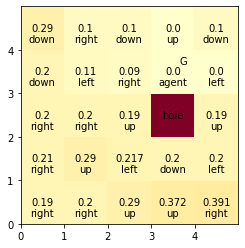

s:(2, 0)　a:right s':(3, 0) a':left
----
s:(3, 0)　a:left s':(2, 0) a':left
----
s:(2, 0)　a:left s':(1, 0) a':down
----
s:(1, 0)　a:down s':(1, 0) a':down
----
s:(1, 0)　a:down s':(1, 0) a':up
----
s:(1, 0)　a:up s':(1, 1) a':down
----
s:(1, 1)　a:down s':(1, 0) a':left
----
s:(1, 0)　a:left s':(0, 0) a':up
----
s:(0, 0)　a:up s':(0, 1) a':up
----
s:(0, 1)　a:up s':(0, 2) a':up
----
s:(0, 2)　a:up s':(0, 3) a':right
----
s:(0, 3)　a:right s':(1, 3) a':right
----
s:(1, 3)　a:right s':(2, 3) a':right
----
s:(2, 3)　a:right s':(3, 3) a':up
----


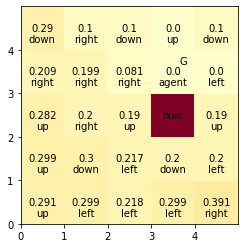

s:(0, 3)　a:up s':(0, 4) a':right
----
s:(0, 4)　a:right s':(1, 4) a':left
----
s:(1, 4)　a:left s':(0, 4) a':up
----
s:(0, 4)　a:up s':(0, 4) a':up
----
s:(0, 4)　a:up s':(0, 4) a':down
----
s:(0, 4)　a:down s':(0, 3) a':left
----
s:(0, 3)　a:left s':(0, 3) a':left
----
s:(0, 3)　a:left s':(0, 3) a':down
----
s:(0, 3)　a:down s':(0, 2) a':down
----
s:(0, 2)　a:down s':(0, 1) a':down
----
s:(0, 1)　a:down s':(0, 0) a':down
----
s:(0, 0)　a:down s':(0, 0) a':down
----
s:(0, 0)　a:down s':(0, 0) a':left
----
s:(0, 0)　a:left s':(0, 0) a':left
----
s:(0, 0)　a:left s':(0, 0) a':right
----
s:(0, 0)　a:right s':(1, 0) a':right
----
s:(1, 0)　a:right s':(2, 0) a':down
----
s:(2, 0)　a:down s':(2, 0) a':down
----
s:(2, 0)　a:down s':(2, 0) a':right
----
s:(2, 0)　a:right s':(3, 0) a':down
----
s:(3, 0)　a:down s':(3, 0) a':down
----
s:(3, 0)　a:down s':(3, 0) a':left
----
s:(3, 0)　a:left s':(2, 0) a':left
----
s:(2, 0)　a:left s':(1, 0) a':left
----
s:(1, 0)　a:left s':(0, 0) a':up
----
s:(0, 0)　a:up s':(0, 1) a':le

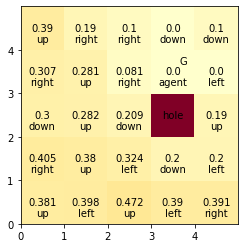

s:(1, 1)　a:down s':(1, 0) a':right
----
s:(1, 0)　a:right s':(2, 0) a':right
----
s:(2, 0)　a:right s':(3, 0) a':right
----
s:(3, 0)　a:right s':(4, 0) a':up
----
s:(4, 0)　a:up s':(4, 1) a':up
----
s:(4, 1)　a:up s':(4, 2) a':down
----
s:(4, 2)　a:down s':(4, 1) a':down
----
s:(4, 1)　a:down s':(4, 0) a':down
----
s:(4, 0)　a:down s':(4, 0) a':down
----
s:(4, 0)　a:down s':(4, 0) a':left
----
s:(4, 0)　a:left s':(3, 0) a':up
----
s:(3, 0)　a:up s':(3, 1) a':right
----
s:(3, 1)　a:right s':(4, 1) a':up
----
s:(4, 1)　a:up s':(4, 2) a':up
----
s:(4, 2)　a:up s':(4, 3) a':left
----
s:(4, 3)　a:left s':(3, 3) a':up
----


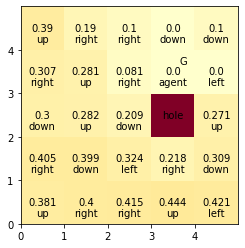

s:(1, 3)　a:down s':(1, 2) a':down
----
s:(1, 2)　a:down s':(1, 1) a':left
----
s:(1, 1)　a:left s':(1, 1) a':left
----
s:(1, 1)　a:left s':(0, 1) a':up
----
s:(0, 1)　a:up s':(0, 2) a':right
----
s:(0, 2)　a:right s':(1, 2) a':left
----
s:(1, 2)　a:left s':(0, 2) a':left
----
s:(0, 2)　a:left s':(0, 2) a':left
----
s:(0, 2)　a:left s':(0, 2) a':up
----
s:(0, 2)　a:up s':(0, 3) a':up
----
s:(0, 3)　a:up s':(0, 4) a':left
----
s:(0, 4)　a:left s':(0, 4) a':left
----
s:(0, 4)　a:left s':(0, 4) a':right
----
s:(0, 4)　a:right s':(1, 4) a':up
----
s:(1, 4)　a:up s':(1, 4) a':up
----
s:(1, 4)　a:up s':(1, 4) a':down
----
s:(1, 4)　a:down s':(1, 3) a':right
----
s:(1, 3)　a:right s':(2, 3) a':right
----
s:(2, 3)　a:right s':(3, 3) a':up
----


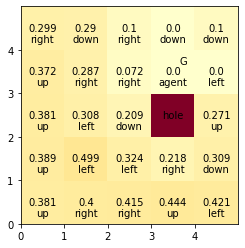

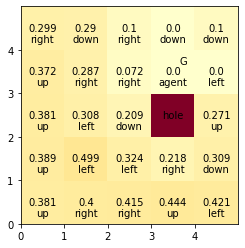

s:(4, 1)　a:left s':(3, 1) a':down
----
s:(3, 1)　a:down s':(3, 0) a':left
----
s:(3, 0)　a:left s':(2, 0) a':left
----
s:(2, 0)　a:left s':(1, 0) a':up
----
s:(1, 0)　a:up s':(1, 1) a':right
----
s:(1, 1)　a:right s':(1, 1) a':right
----
s:(1, 1)　a:right s':(2, 1) a':up
----
s:(2, 1)　a:up s':(2, 2) a':left
----
s:(2, 2)　a:left s':(1, 2) a':right
----
s:(1, 2)　a:right s':(1, 2) a':right
----
s:(1, 2)　a:right s':(2, 2) a':up
----
s:(2, 2)　a:up s':(2, 3) a':right
----
s:(2, 3)　a:right s':(3, 3) a':up
----


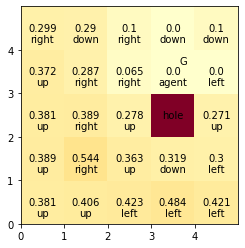

s:(4, 1)　a:right s':(4, 1) a':right
----
s:(4, 1)　a:right s':(4, 1) a':left
----
s:(4, 1)　a:left s':(3, 1) a':left
----
s:(3, 1)　a:left s':(2, 1) a':right
----
s:(2, 1)　a:right s':(3, 1) a':right
----
s:(3, 1)　a:right s':(4, 1) a':down
----
s:(4, 1)　a:down s':(4, 1) a':down
----
s:(4, 1)　a:down s':(4, 0) a':left
----
s:(4, 0)　a:left s':(3, 0) a':right
----
s:(3, 0)　a:right s':(4, 0) a':up
----
s:(4, 0)　a:up s':(4, 1) a':up
----
s:(4, 1)　a:up s':(4, 1) a':up
----
s:(4, 1)　a:up s':(4, 2) a':right
----
s:(4, 2)　a:right s':(4, 2) a':right
----
s:(4, 2)　a:right s':(4, 2) a':up
----
s:(4, 2)　a:up s':(4, 3) a':left
----
s:(4, 3)　a:left s':(3, 3) a':up
----


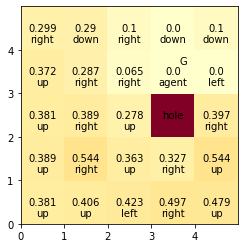

s:(2, 1)　a:down s':(2, 0) a':down
----
s:(2, 0)　a:down s':(2, 0) a':down
----
s:(2, 0)　a:down s':(2, 0) a':right
----
s:(2, 0)　a:right s':(2, 0) a':right
----
s:(2, 0)　a:right s':(3, 0) a':up
----
s:(3, 0)　a:up s':(3, 1) a':left
----
s:(3, 1)　a:left s':(2, 1) a':left
----
s:(2, 1)　a:left s':(1, 1) a':up
----
s:(1, 1)　a:up s':(1, 2) a':up
----
s:(1, 2)　a:up s':(1, 3) a':left
----
s:(1, 3)　a:left s':(0, 3) a':down
----
s:(0, 3)　a:down s':(0, 2) a':down
----
s:(0, 2)　a:down s':(0, 1) a':down
----
s:(0, 1)　a:down s':(0, 0) a':right
----
s:(0, 0)　a:right s':(0, 0) a':right
----
s:(0, 0)　a:right s':(1, 0) a':down
----
s:(1, 0)　a:down s':(1, 0) a':down
----
s:(1, 0)　a:down s':(1, 0) a':left
----
s:(1, 0)　a:left s':(0, 0) a':up
----
s:(0, 0)　a:up s':(0, 1) a':right
----
s:(0, 1)　a:right s':(1, 1) a':down
----
s:(1, 1)　a:down s':(1, 1) a':down
----
s:(1, 1)　a:down s':(1, 0) a':right
----
s:(1, 0)　a:right s':(2, 0) a':left
----
s:(2, 0)　a:left s':(1, 0) a':up
----
s:(1, 0)　a:up s':(1, 1) a':up
-

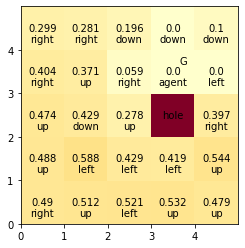

s:(1, 4)　a:left s':(0, 4) a':left
----
s:(0, 4)　a:left s':(0, 4) a':right
----
s:(0, 4)　a:right s':(1, 4) a':right
----
s:(1, 4)　a:right s':(2, 4) a':left
----
s:(2, 4)　a:left s':(1, 4) a':down
----
s:(1, 4)　a:down s':(1, 3) a':right
----
s:(1, 3)　a:right s':(2, 3) a':right
----
s:(2, 3)　a:right s':(2, 3) a':right
----
s:(2, 3)　a:right s':(3, 3) a':up
----


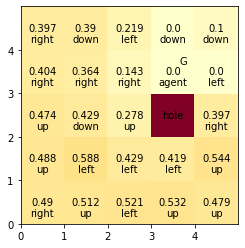

s:(1, 4)　a:left s':(0, 4) a':right
----
s:(0, 4)　a:right s':(1, 4) a':right
----
s:(1, 4)　a:right s':(1, 4) a':right
----
s:(1, 4)　a:right s':(2, 4) a':right
----
s:(2, 4)　a:right s':(3, 4) a':down
----
s:(3, 4)　a:down s':(3, 3) a':up
----


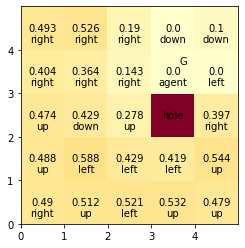

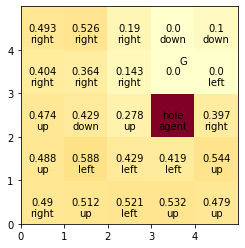

s:(4, 3)　a:left s':(3, 3) a':up
----


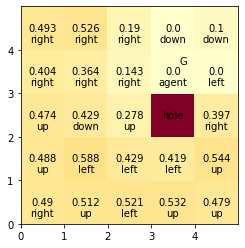

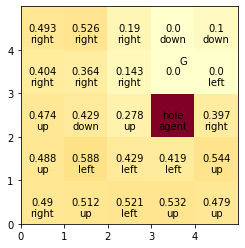

s:(2, 3)　a:up s':(2, 4) a':up
----
s:(2, 4)　a:up s':(2, 4) a':up
----
s:(2, 4)　a:up s':(2, 4) a':down
----
s:(2, 4)　a:down s':(2, 3) a':down
----
s:(2, 3)　a:down s':(2, 2) a':down
----
s:(2, 2)　a:down s':(2, 1) a':up
----
s:(2, 1)　a:up s':(2, 1) a':up
----
s:(2, 1)　a:up s':(2, 2) a':left
----
s:(2, 2)　a:left s':(1, 2) a':up
----
s:(1, 2)　a:up s':(1, 3) a':down
----
s:(1, 3)　a:down s':(1, 2) a':up
----
s:(1, 2)　a:up s':(1, 3) a':left
----
s:(1, 3)　a:left s':(0, 3) a':left
----
s:(0, 3)　a:left s':(0, 3) a':right
----
s:(0, 3)　a:right s':(1, 3) a':right
----
s:(1, 3)　a:right s':(2, 3) a':right
----
s:(2, 3)　a:right s':(3, 3) a':up
----


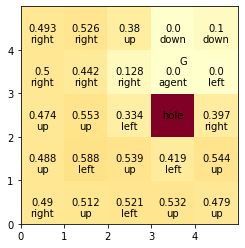

s:(2, 0)　a:up s':(2, 1) a':right
----
s:(2, 1)　a:right s':(3, 1) a':down
----
s:(3, 1)　a:down s':(3, 0) a':down
----
s:(3, 0)　a:down s':(3, 0) a':down
----
s:(3, 0)　a:down s':(3, 0) a':right
----
s:(3, 0)　a:right s':(4, 0) a':down
----
s:(4, 0)　a:down s':(4, 0) a':right
----
s:(4, 0)　a:right s':(4, 0) a':left
----
s:(4, 0)　a:left s':(3, 0) a':left
----
s:(3, 0)　a:left s':(2, 0) a':left
----
s:(2, 0)　a:left s':(1, 0) a':left
----
s:(1, 0)　a:left s':(0, 0) a':down
----
s:(0, 0)　a:down s':(0, 0) a':down
----
s:(0, 0)　a:down s':(0, 0) a':left
----
s:(0, 0)　a:left s':(0, 0) a':left
----
s:(0, 0)　a:left s':(0, 0) a':left
----
s:(0, 0)　a:left s':(0, 0) a':up
----
s:(0, 0)　a:up s':(0, 1) a':left
----
s:(0, 1)　a:left s':(0, 1) a':left
----
s:(0, 1)　a:left s':(0, 1) a':down
----
s:(0, 1)　a:down s':(0, 0) a':right
----
s:(0, 0)　a:right s':(1, 0) a':right
----
s:(1, 0)　a:right s':(2, 0) a':up
----
s:(2, 0)　a:up s':(2, 1) a':left
----
s:(2, 1)　a:left s':(1, 1) a':right
----
s:(1, 1)　a:right s':(2, 

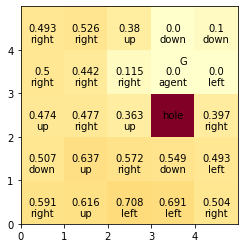

s:(4, 3)　a:left s':(3, 3) a':up
----


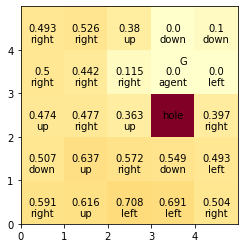

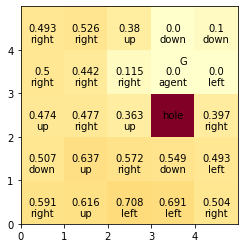

s:(0, 3)　a:up s':(0, 4) a':left
----
s:(0, 4)　a:left s':(0, 4) a':down
----
s:(0, 4)　a:down s':(0, 3) a':down
----
s:(0, 3)　a:down s':(0, 2) a':down
----
s:(0, 2)　a:down s':(0, 1) a':up
----
s:(0, 1)　a:up s':(0, 2) a':right
----
s:(0, 2)　a:right s':(1, 2) a':left
----
s:(1, 2)　a:left s':(0, 2) a':left
----
s:(0, 2)　a:left s':(0, 2) a':down
----
s:(0, 2)　a:down s':(0, 1) a':right
----
s:(0, 1)　a:right s':(1, 1) a':left
----
s:(1, 1)　a:left s':(0, 1) a':down
----
s:(0, 1)　a:down s':(0, 0) a':down
----
s:(0, 0)　a:down s':(0, 0) a':down
----
s:(0, 0)　a:down s':(0, 0) a':up
----
s:(0, 0)　a:up s':(0, 1) a':up
----
s:(0, 1)　a:up s':(0, 2) a':right
----
s:(0, 2)　a:right s':(1, 2) a':down
----
s:(1, 2)　a:down s':(1, 1) a':down
----
s:(1, 1)　a:down s':(1, 0) a':down
----
s:(1, 0)　a:down s':(1, 0) a':down
----
s:(1, 0)　a:down s':(1, 0) a':left
----
s:(1, 0)　a:left s':(0, 0) a':right
----
s:(0, 0)　a:right s':(1, 0) a':right
----
s:(1, 0)　a:right s':(2, 0) a':up
----
s:(2, 0)　a:up s':(2, 0) a':up
-

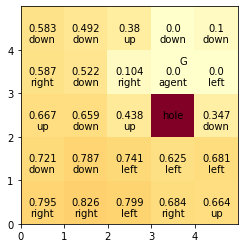

s:(2, 2)　a:up s':(2, 3) a':right
----
s:(2, 3)　a:right s':(3, 3) a':up
----


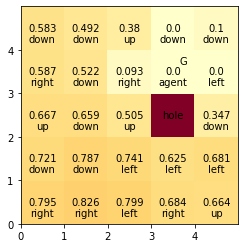

s:(4, 4)　a:left s':(3, 4) a':left
----
s:(3, 4)　a:left s':(2, 4) a':right
----
s:(2, 4)　a:right s':(3, 4) a':up
----
s:(3, 4)　a:up s':(3, 4) a':down
----
s:(3, 4)　a:down s':(3, 3) a':up
----


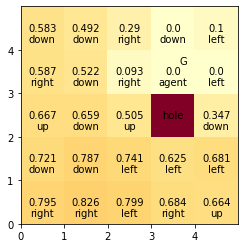

s:(0, 3)　a:up s':(0, 4) a':right
----
s:(0, 4)　a:right s':(1, 4) a':left
----
s:(1, 4)　a:left s':(0, 4) a':left
----
s:(0, 4)　a:left s':(0, 4) a':left
----
s:(0, 4)　a:left s':(0, 4) a':up
----
s:(0, 4)　a:up s':(0, 4) a':down
----
s:(0, 4)　a:down s':(0, 3) a':right
----
s:(0, 3)　a:right s':(1, 3) a':left
----
s:(1, 3)　a:left s':(0, 3) a':down
----
s:(0, 3)　a:down s':(0, 2) a':right
----
s:(0, 2)　a:right s':(1, 2) a':up
----
s:(1, 2)　a:up s':(1, 3) a':right
----
s:(1, 3)　a:right s':(2, 3) a':right
----
s:(2, 3)　a:right s':(3, 3) a':right
----


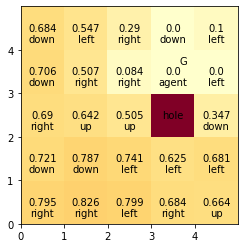

s:(1, 1)　a:up s':(1, 2) a':right
----
s:(1, 2)　a:right s':(2, 2) a':down
----
s:(2, 2)　a:down s':(2, 1) a':right
----
s:(2, 1)　a:right s':(3, 1) a':down
----
s:(3, 1)　a:down s':(3, 0) a':right
----
s:(3, 0)　a:right s':(4, 0) a':left
----
s:(4, 0)　a:left s':(3, 0) a':up
----
s:(3, 0)　a:up s':(3, 1) a':right
----
s:(3, 1)　a:right s':(3, 1) a':right
----
s:(3, 1)　a:right s':(4, 1) a':right
----
s:(4, 1)　a:right s':(4, 1) a':right
----
s:(4, 1)　a:right s':(4, 1) a':down
----
s:(4, 1)　a:down s':(4, 0) a':up
----
s:(4, 0)　a:up s':(4, 1) a':up
----
s:(4, 1)　a:up s':(4, 2) a':up
----
s:(4, 2)　a:up s':(4, 3) a':left
----
s:(4, 3)　a:left s':(3, 3) a':up
----


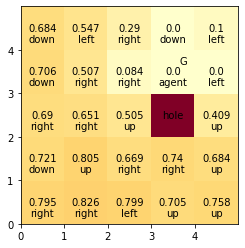

s:(1, 3)　a:down s':(1, 2) a':left
----
s:(1, 2)　a:left s':(0, 2) a':down
----
s:(0, 2)　a:down s':(0, 1) a':up
----
s:(0, 1)　a:up s':(0, 1) a':up
----
s:(0, 1)　a:up s':(0, 2) a':up
----
s:(0, 2)　a:up s':(0, 3) a':left
----
s:(0, 3)　a:left s':(0, 3) a':up
----
s:(0, 3)　a:up s':(0, 3) a':up
----
s:(0, 3)　a:up s':(0, 4) a':left
----
s:(0, 4)　a:left s':(0, 4) a':right
----
s:(0, 4)　a:right s':(1, 4) a':down
----
s:(1, 4)　a:down s':(1, 3) a':up
----
s:(1, 3)　a:up s':(1, 4) a':right
----
s:(1, 4)　a:right s':(2, 4) a':left
----
s:(2, 4)　a:left s':(1, 4) a':left
----
s:(1, 4)　a:left s':(0, 4) a':right
----
s:(0, 4)　a:right s':(1, 4) a':up
----
s:(1, 4)　a:up s':(1, 4) a':up
----
s:(1, 4)　a:up s':(1, 4) a':down
----
s:(1, 4)　a:down s':(1, 3) a':right
----
s:(1, 3)　a:right s':(2, 3) a':left
----
s:(2, 3)　a:left s':(1, 3) a':left
----
s:(1, 3)　a:left s':(0, 3) a':right
----
s:(0, 3)　a:right s':(1, 3) a':right
----
s:(1, 3)　a:right s':(2, 3) a':right
----
s:(2, 3)　a:right s':(3, 3) a':up
----


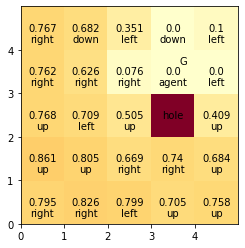

s:(1, 4)　a:right s':(2, 4) a':down
----
s:(2, 4)　a:down s':(2, 4) a':down
----
s:(2, 4)　a:down s':(2, 3) a':right
----
s:(2, 3)　a:right s':(2, 3) a':right
----
s:(2, 3)　a:right s':(3, 3) a':up
----


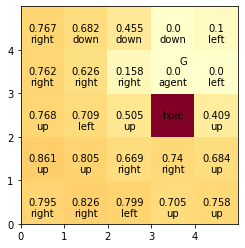

s:(1, 3)　a:up s':(1, 4) a':left
----
s:(1, 4)　a:left s':(1, 4) a':left
----
s:(1, 4)　a:left s':(0, 4) a':down
----
s:(0, 4)　a:down s':(0, 4) a':down
----
s:(0, 4)　a:down s':(0, 3) a':up
----
s:(0, 3)　a:up s':(0, 4) a':up
----
s:(0, 4)　a:up s':(0, 4) a':up
----
s:(0, 4)　a:up s':(0, 4) a':right
----
s:(0, 4)　a:right s':(1, 4) a':right
----
s:(1, 4)　a:right s':(2, 4) a':right
----
s:(2, 4)　a:right s':(3, 4) a':down
----
s:(3, 4)　a:down s':(3, 4) a':down
----
s:(3, 4)　a:down s':(3, 3) a':up
----


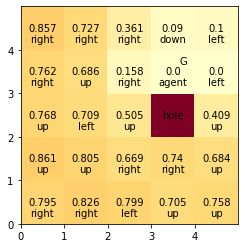

s:(0, 0)　a:down s':(0, 0) a':up
----
s:(0, 0)　a:up s':(0, 1) a':right
----
s:(0, 1)　a:right s':(1, 1) a':right
----
s:(1, 1)　a:right s':(2, 1) a':down
----
s:(2, 1)　a:down s':(2, 0) a':down
----
s:(2, 0)　a:down s':(2, 0) a':down
----
s:(2, 0)　a:down s':(2, 0) a':right
----
s:(2, 0)　a:right s':(2, 0) a':right
----
s:(2, 0)　a:right s':(3, 0) a':down
----
s:(3, 0)　a:down s':(3, 0) a':down
----
s:(3, 0)　a:down s':(3, 0) a':left
----
s:(3, 0)　a:left s':(2, 0) a':left
----
s:(2, 0)　a:left s':(1, 0) a':down
----
s:(1, 0)　a:down s':(1, 0) a':down
----
s:(1, 0)　a:down s':(1, 0) a':left
----
s:(1, 0)　a:left s':(0, 0) a':right
----
s:(0, 0)　a:right s':(1, 0) a':up
----
s:(1, 0)　a:up s':(1, 1) a':left
----
s:(1, 1)　a:left s':(0, 1) a':down
----
s:(0, 1)　a:down s':(0, 0) a':left
----
s:(0, 0)　a:left s':(0, 0) a':left
----
s:(0, 0)　a:left s':(0, 0) a':down
----
s:(0, 0)　a:down s':(0, 0) a':down
----
s:(0, 0)　a:down s':(0, 0) a':right
----
s:(0, 0)　a:right s':(1, 0) a':right
----
s:(1, 0)　a:right s':

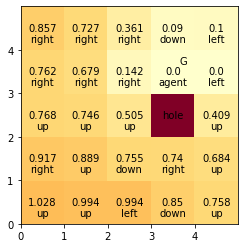

s:(1, 3)　a:down s':(1, 3) a':down
----
s:(1, 3)　a:down s':(1, 2) a':right
----
s:(1, 2)　a:right s':(1, 2) a':right
----
s:(1, 2)　a:right s':(2, 2) a':left
----
s:(2, 2)　a:left s':(1, 2) a':down
----
s:(1, 2)　a:down s':(1, 1) a':right
----
s:(1, 1)　a:right s':(2, 1) a':right
----
s:(2, 1)　a:right s':(3, 1) a':left
----
s:(3, 1)　a:left s':(2, 1) a':down
----
s:(2, 1)　a:down s':(2, 0) a':up
----
s:(2, 0)　a:up s':(2, 1) a':up
----
s:(2, 1)　a:up s':(2, 2) a':up
----
s:(2, 2)　a:up s':(2, 3) a':right
----
s:(2, 3)　a:right s':(3, 3) a':up
----


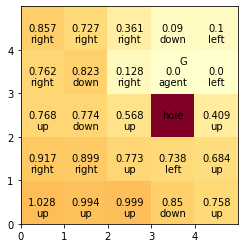

s:(1, 1)　a:left s':(0, 1) a':down
----
s:(0, 1)　a:down s':(0, 0) a':down
----
s:(0, 0)　a:down s':(0, 0) a':right
----
s:(0, 0)　a:right s':(1, 0) a':down
----
s:(1, 0)　a:down s':(1, 0) a':down
----
s:(1, 0)　a:down s':(1, 0) a':left
----
s:(1, 0)　a:left s':(0, 0) a':up
----
s:(0, 0)　a:up s':(0, 1) a':up
----
s:(0, 1)　a:up s':(0, 2) a':right
----
s:(0, 2)　a:right s':(1, 2) a':left
----
s:(1, 2)　a:left s':(0, 2) a':down
----
s:(0, 2)　a:down s':(0, 1) a':right
----
s:(0, 1)　a:right s':(1, 1) a':up
----
s:(1, 1)　a:up s':(1, 2) a':up
----
s:(1, 2)　a:up s':(1, 3) a':left
----
s:(1, 3)　a:left s':(0, 3) a':down
----
s:(0, 3)　a:down s':(0, 2) a':left
----
s:(0, 2)　a:left s':(0, 2) a':right
----
s:(0, 2)　a:right s':(1, 2) a':down
----
s:(1, 2)　a:down s':(1, 1) a':right
----
s:(1, 1)　a:right s':(2, 1) a':left
----
s:(2, 1)　a:left s':(2, 1) a':left
----
s:(2, 1)　a:left s':(1, 1) a':down
----
s:(1, 1)　a:down s':(1, 0) a':up
----
s:(1, 0)　a:up s':(1, 1) a':left
----
s:(1, 1)　a:left s':(0, 1) a':up
---

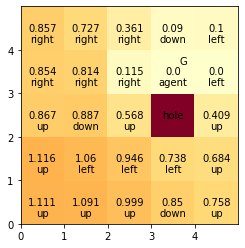

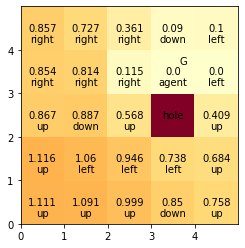

s:(4, 0)　a:right s':(4, 0) a':right
----
s:(4, 0)　a:right s':(4, 0) a':left
----
s:(4, 0)　a:left s':(3, 0) a':up
----
s:(3, 0)　a:up s':(3, 1) a':down
----
s:(3, 1)　a:down s':(3, 0) a':right
----
s:(3, 0)　a:right s':(4, 0) a':up
----
s:(4, 0)　a:up s':(4, 0) a':up
----
s:(4, 0)　a:up s':(4, 1) a':left
----
s:(4, 1)　a:left s':(3, 1) a':left
----
s:(3, 1)　a:left s':(2, 1) a':right
----
s:(2, 1)　a:right s':(3, 1) a':right
----
s:(3, 1)　a:right s':(4, 1) a':up
----
s:(4, 1)　a:up s':(4, 2) a':down
----
s:(4, 2)　a:down s':(4, 1) a':down
----
s:(4, 1)　a:down s':(4, 0) a':down
----
s:(4, 0)　a:down s':(4, 0) a':down
----
s:(4, 0)　a:down s':(4, 0) a':left
----
s:(4, 0)　a:left s':(3, 0) a':up
----
s:(3, 0)　a:up s':(3, 1) a':down
----
s:(3, 1)　a:down s':(3, 0) a':left
----
s:(3, 0)　a:left s':(2, 0) a':down
----
s:(2, 0)　a:down s':(2, 0) a':down
----
s:(2, 0)　a:down s':(2, 0) a':right
----
s:(2, 0)　a:right s':(3, 0) a':down
----
s:(3, 0)　a:down s':(3, 0) a':down
----
s:(3, 0)　a:down s':(3, 0) a':right

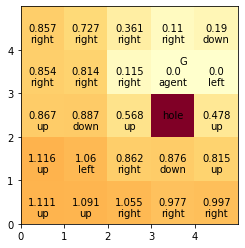

s:(0, 1)　a:down s':(0, 1) a':down
----
s:(0, 1)　a:down s':(0, 0) a':left
----
s:(0, 0)　a:left s':(0, 0) a':left
----
s:(0, 0)　a:left s':(0, 0) a':right
----
s:(0, 0)　a:right s':(1, 0) a':right
----
s:(1, 0)　a:right s':(2, 0) a':left
----
s:(2, 0)　a:left s':(1, 0) a':up
----
s:(1, 0)　a:up s':(1, 1) a':up
----
s:(1, 1)　a:up s':(1, 2) a':left
----
s:(1, 2)　a:left s':(0, 2) a':down
----
s:(0, 2)　a:down s':(0, 1) a':left
----
s:(0, 1)　a:left s':(0, 1) a':left
----
s:(0, 1)　a:left s':(0, 1) a':right
----
s:(0, 1)　a:right s':(1, 1) a':right
----
s:(1, 1)　a:right s':(2, 1) a':right
----
s:(2, 1)　a:right s':(3, 1) a':right
----
s:(3, 1)　a:right s':(3, 1) a':right
----
s:(3, 1)　a:right s':(4, 1) a':left
----
s:(4, 1)　a:left s':(3, 1) a':left
----
s:(3, 1)　a:left s':(2, 1) a':up
----
s:(2, 1)　a:up s':(2, 2) a':down
----
s:(2, 2)　a:down s':(2, 1) a':down
----
s:(2, 1)　a:down s':(2, 0) a':up
----
s:(2, 0)　a:up s':(2, 1) a':up
----
s:(2, 1)　a:up s':(2, 2) a':up
----
s:(2, 2)　a:up s':(2, 3) a':right


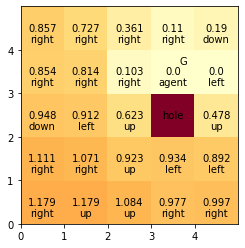

s:(0, 4)　a:left s':(0, 4) a':left
----
s:(0, 4)　a:left s':(0, 4) a':right
----
s:(0, 4)　a:right s':(1, 4) a':down
----
s:(1, 4)　a:down s':(1, 3) a':up
----
s:(1, 3)　a:up s':(1, 4) a':right
----
s:(1, 4)　a:right s':(1, 4) a':right
----
s:(1, 4)　a:right s':(2, 4) a':left
----
s:(2, 4)　a:left s':(1, 4) a':up
----
s:(1, 4)　a:up s':(1, 4) a':up
----
s:(1, 4)　a:up s':(1, 4) a':down
----
s:(1, 4)　a:down s':(1, 3) a':left
----
s:(1, 3)　a:left s':(0, 3) a':left
----
s:(0, 3)　a:left s':(0, 3) a':left
----
s:(0, 3)　a:left s':(0, 3) a':down
----
s:(0, 3)　a:down s':(0, 2) a':left
----
s:(0, 2)　a:left s':(0, 2) a':left
----
s:(0, 2)　a:left s':(0, 2) a':up
----
s:(0, 2)　a:up s':(0, 3) a':right
----
s:(0, 3)　a:right s':(1, 3) a':right
----
s:(1, 3)　a:right s':(1, 3) a':right
----
s:(1, 3)　a:right s':(2, 3) a':right
----
s:(2, 3)　a:right s':(3, 3) a':up
----


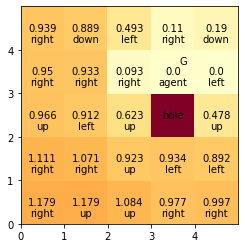

s:(1, 2)　a:left s':(0, 2) a':right
----
s:(0, 2)　a:right s':(1, 2) a':right
----
s:(1, 2)　a:right s':(2, 2) a':left
----
s:(2, 2)　a:left s':(1, 2) a':up
----
s:(1, 2)　a:up s':(1, 2) a':up
----
s:(1, 2)　a:up s':(1, 3) a':down
----
s:(1, 3)　a:down s':(1, 2) a':down
----
s:(1, 2)　a:down s':(1, 1) a':down
----
s:(1, 1)　a:down s':(1, 0) a':left
----
s:(1, 0)　a:left s':(1, 0) a':left
----
s:(1, 0)　a:left s':(0, 0) a':up
----
s:(0, 0)　a:up s':(0, 1) a':right
----
s:(0, 1)　a:right s':(0, 1) a':right
----
s:(0, 1)　a:right s':(1, 1) a':up
----
s:(1, 1)　a:up s':(1, 2) a':right
----
s:(1, 2)　a:right s':(2, 2) a':up
----
s:(2, 2)　a:up s':(2, 3) a':right
----
s:(2, 3)　a:right s':(3, 3) a':up
----


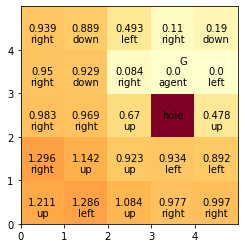

s:(1, 2)　a:right s':(2, 2) a':up
----
s:(2, 2)　a:up s':(2, 3) a':left
----
s:(2, 3)　a:left s':(1, 3) a':left
----
s:(1, 3)　a:left s':(0, 3) a':down
----
s:(0, 3)　a:down s':(0, 2) a':down
----
s:(0, 2)　a:down s':(0, 2) a':down
----
s:(0, 2)　a:down s':(0, 1) a':up
----
s:(0, 1)　a:up s':(0, 2) a':up
----
s:(0, 2)　a:up s':(0, 3) a':left
----
s:(0, 3)　a:left s':(0, 3) a':up
----
s:(0, 3)　a:up s':(0, 3) a':up
----
s:(0, 3)　a:up s':(0, 4) a':up
----
s:(0, 4)　a:up s':(0, 4) a':up
----
s:(0, 4)　a:up s':(0, 4) a':down
----
s:(0, 4)　a:down s':(0, 3) a':right
----
s:(0, 3)　a:right s':(1, 3) a':up
----
s:(1, 3)　a:up s':(1, 4) a':left
----
s:(1, 4)　a:left s':(1, 4) a':left
----
s:(1, 4)　a:left s':(0, 4) a':right
----
s:(0, 4)　a:right s':(1, 4) a':right
----
s:(1, 4)　a:right s':(2, 4) a':right
----
s:(2, 4)　a:right s':(3, 4) a':down
----
s:(3, 4)　a:down s':(3, 3) a':up
----


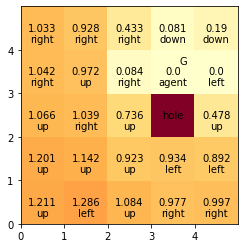

s:(2, 4)　a:left s':(1, 4) a':down
----
s:(1, 4)　a:down s':(1, 3) a':down
----
s:(1, 3)　a:down s':(1, 2) a':down
----
s:(1, 2)　a:down s':(1, 1) a':left
----
s:(1, 1)　a:left s':(0, 1) a':down
----
s:(0, 1)　a:down s':(0, 0) a':down
----
s:(0, 0)　a:down s':(0, 0) a':down
----
s:(0, 0)　a:down s':(0, 0) a':right
----
s:(0, 0)　a:right s':(1, 0) a':right
----
s:(1, 0)　a:right s':(2, 0) a':right
----
s:(2, 0)　a:right s':(3, 0) a':up
----
s:(3, 0)　a:up s':(3, 1) a':down
----
s:(3, 1)　a:down s':(3, 0) a':left
----
s:(3, 0)　a:left s':(2, 0) a':up
----
s:(2, 0)　a:up s':(2, 1) a':up
----
s:(2, 1)　a:up s':(2, 2) a':down
----
s:(2, 2)　a:down s':(2, 1) a':left
----
s:(2, 1)　a:left s':(1, 1) a':right
----
s:(1, 1)　a:right s':(2, 1) a':right
----
s:(2, 1)　a:right s':(3, 1) a':left
----
s:(3, 1)　a:left s':(2, 1) a':down
----
s:(2, 1)　a:down s':(2, 0) a':left
----
s:(2, 0)　a:left s':(1, 0) a':down
----
s:(1, 0)　a:down s':(1, 0) a':down
----
s:(1, 0)　a:down s':(1, 0) a':up
----
s:(1, 0)　a:up s':(1, 1) a':do

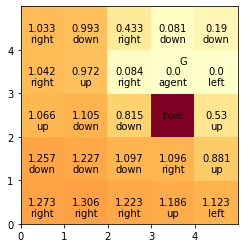

s:(2, 1)　a:up s':(2, 2) a':left
----
s:(2, 2)　a:left s':(1, 2) a':left
----
s:(1, 2)　a:left s':(1, 2) a':left
----
s:(1, 2)　a:left s':(0, 2) a':up
----
s:(0, 2)　a:up s':(0, 3) a':down
----
s:(0, 3)　a:down s':(0, 2) a':right
----
s:(0, 2)　a:right s':(1, 2) a':up
----
s:(1, 2)　a:up s':(1, 3) a':right
----
s:(1, 3)　a:right s':(2, 3) a':right
----
s:(2, 3)　a:right s':(3, 3) a':up
----


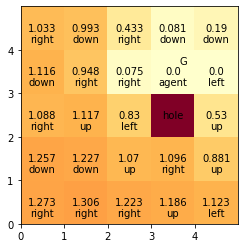

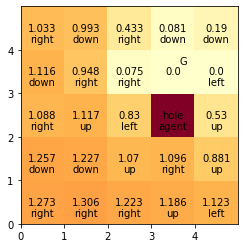

s:(4, 4)　a:right s':(4, 4) a':down
----
s:(4, 4)　a:down s':(4, 3) a':left
----
s:(4, 3)　a:left s':(4, 3) a':down
----
s:(4, 3)　a:down s':(4, 3) a':right
----
s:(4, 3)　a:right s':(4, 3) a':right
----
s:(4, 3)　a:right s':(4, 3) a':up
----
s:(4, 3)　a:up s':(4, 4) a':up
----
s:(4, 4)　a:up s':(4, 4) a':up
----
s:(4, 4)　a:up s':(4, 4) a':left
----
s:(4, 4)　a:left s':(3, 4) a':down
----
s:(3, 4)　a:down s':(3, 3) a':up
----


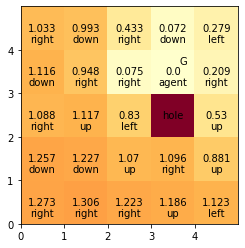

s:(0, 3)　a:down s':(0, 2) a':left
----
s:(0, 2)　a:left s':(0, 2) a':left
----
s:(0, 2)　a:left s':(0, 2) a':right
----
s:(0, 2)　a:right s':(1, 2) a':right
----
s:(1, 2)　a:right s':(2, 2) a':up
----
s:(2, 2)　a:up s':(2, 3) a':right
----
s:(2, 3)　a:right s':(3, 3) a':up
----


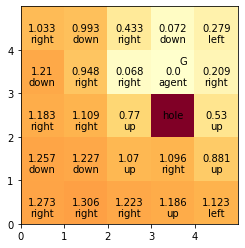

s:(3, 4)　a:down s':(3, 3) a':up
----


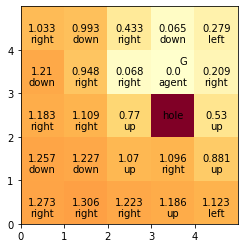

s:(0, 2)　a:down s':(0, 1) a':left
----
s:(0, 1)　a:left s':(0, 1) a':left
----
s:(0, 1)　a:left s':(0, 1) a':up
----
s:(0, 1)　a:up s':(0, 1) a':up
----
s:(0, 1)　a:up s':(0, 2) a':up
----
s:(0, 2)　a:up s':(0, 3) a':right
----
s:(0, 3)　a:right s':(1, 3) a':right
----
s:(1, 3)　a:right s':(2, 3) a':right
----
s:(2, 3)　a:right s':(3, 3) a':up
----


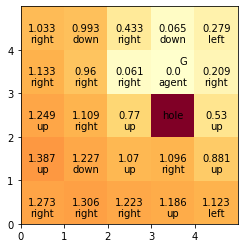

s:(2, 0)　a:down s':(2, 0) a':down
----
s:(2, 0)　a:down s':(2, 0) a':up
----
s:(2, 0)　a:up s':(2, 1) a':up
----
s:(2, 1)　a:up s':(2, 2) a':up
----
s:(2, 2)　a:up s':(2, 3) a':right
----
s:(2, 3)　a:right s':(3, 3) a':up
----


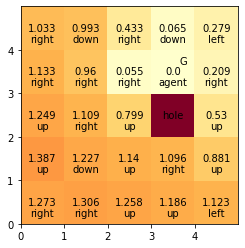

s:(0, 3)　a:left s':(0, 3) a':left
----
s:(0, 3)　a:left s':(0, 3) a':up
----
s:(0, 3)　a:up s':(0, 4) a':down
----
s:(0, 4)　a:down s':(0, 3) a':right
----
s:(0, 3)　a:right s':(1, 3) a':right
----
s:(1, 3)　a:right s':(2, 3) a':right
----
s:(2, 3)　a:right s':(3, 3) a':up
----


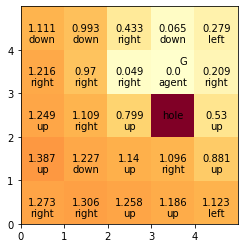

s:(0, 4)　a:up s':(0, 4) a':right
----
s:(0, 4)　a:right s':(1, 4) a':right
----
s:(1, 4)　a:right s':(2, 4) a':up
----
s:(2, 4)　a:up s':(2, 4) a':up
----
s:(2, 4)　a:up s':(2, 4) a':right
----
s:(2, 4)　a:right s':(3, 4) a':down
----
s:(3, 4)　a:down s':(3, 3) a':up
----


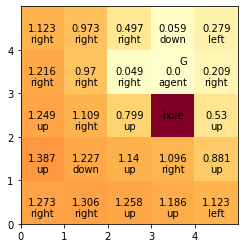

s:(2, 0)　a:left s':(1, 0) a':up
----
s:(1, 0)　a:up s':(1, 1) a':up
----
s:(1, 1)　a:up s':(1, 1) a':up
----
s:(1, 1)　a:up s':(1, 1) a':up
----
s:(1, 1)　a:up s':(1, 2) a':down
----
s:(1, 2)　a:down s':(1, 1) a':right
----
s:(1, 1)　a:right s':(2, 1) a':left
----
s:(2, 1)　a:left s':(2, 1) a':right
----
s:(2, 1)　a:right s':(3, 1) a':left
----
s:(3, 1)　a:left s':(3, 1) a':left
----
s:(3, 1)　a:left s':(2, 1) a':down
----
s:(2, 1)　a:down s':(2, 0) a':right
----
s:(2, 0)　a:right s':(3, 0) a':left
----
s:(3, 0)　a:left s':(3, 0) a':left
----
s:(3, 0)　a:left s':(2, 0) a':up
----
s:(2, 0)　a:up s':(2, 0) a':up
----
s:(2, 0)　a:up s':(2, 1) a':up
----
s:(2, 1)　a:up s':(2, 2) a':up
----
s:(2, 2)　a:up s':(2, 3) a':right
----
s:(2, 3)　a:right s':(3, 3) a':up
----


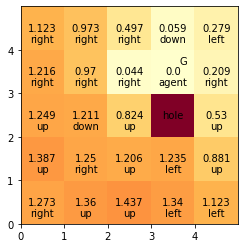

s:(3, 4)　a:down s':(3, 3) a':up
----


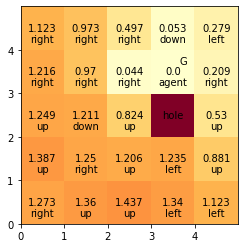

s:(2, 1)　a:right s':(3, 1) a':down
----
s:(3, 1)　a:down s':(3, 0) a':right
----
s:(3, 0)　a:right s':(4, 0) a':up
----
s:(4, 0)　a:up s':(4, 1) a':down
----
s:(4, 1)　a:down s':(4, 0) a':right
----
s:(4, 0)　a:right s':(4, 0) a':right
----
s:(4, 0)　a:right s':(4, 0) a':up
----
s:(4, 0)　a:up s':(4, 1) a':up
----
s:(4, 1)　a:up s':(4, 2) a':down
----
s:(4, 2)　a:down s':(4, 2) a':down
----
s:(4, 2)　a:down s':(4, 1) a':left
----
s:(4, 1)　a:left s':(3, 1) a':right
----
s:(3, 1)　a:right s':(3, 1) a':right
----
s:(3, 1)　a:right s':(4, 1) a':left
----
s:(4, 1)　a:left s':(3, 1) a':left
----
s:(3, 1)　a:left s':(2, 1) a':left
----
s:(2, 1)　a:left s':(1, 1) a':left
----
s:(1, 1)　a:left s':(0, 1) a':down
----
s:(0, 1)　a:down s':(0, 0) a':up
----
s:(0, 0)　a:up s':(0, 1) a':right
----
s:(0, 1)　a:right s':(1, 1) a':up
----
s:(1, 1)　a:up s':(1, 2) a':right
----
s:(1, 2)　a:right s':(1, 2) a':right
----
s:(1, 2)　a:right s':(2, 2) a':down
----
s:(2, 2)　a:down s':(2, 1) a':up
----
s:(2, 1)　a:up s':(2, 2) a':up


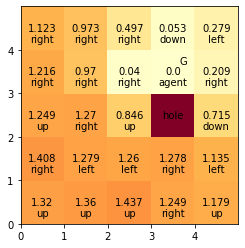

s:(4, 0)　a:left s':(3, 0) a':up
----
s:(3, 0)　a:up s':(3, 0) a':up
----
s:(3, 0)　a:up s':(3, 1) a':down
----
s:(3, 1)　a:down s':(3, 0) a':down
----
s:(3, 0)　a:down s':(3, 0) a':down
----
s:(3, 0)　a:down s':(3, 0) a':up
----
s:(3, 0)　a:up s':(3, 1) a':right
----
s:(3, 1)　a:right s':(4, 1) a':up
----
s:(4, 1)　a:up s':(4, 2) a':up
----
s:(4, 2)　a:up s':(4, 3) a':left
----
s:(4, 3)　a:left s':(3, 3) a':up
----


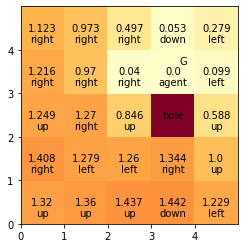

s:(0, 0)　a:left s':(0, 0) a':left
----
s:(0, 0)　a:left s':(0, 0) a':right
----
s:(0, 0)　a:right s':(1, 0) a':left
----
s:(1, 0)　a:left s':(0, 0) a':up
----
s:(0, 0)　a:up s':(0, 1) a':down
----
s:(0, 1)　a:down s':(0, 1) a':down
----
s:(0, 1)　a:down s':(0, 0) a':down
----
s:(0, 0)　a:down s':(0, 0) a':down
----
s:(0, 0)　a:down s':(0, 0) a':right
----
s:(0, 0)　a:right s':(1, 0) a':right
----
s:(1, 0)　a:right s':(2, 0) a':right
----
s:(2, 0)　a:right s':(3, 0) a':down
----
s:(3, 0)　a:down s':(3, 0) a':right
----
s:(3, 0)　a:right s':(4, 0) a':down
----
s:(4, 0)　a:down s':(4, 0) a':down
----
s:(4, 0)　a:down s':(4, 0) a':up
----
s:(4, 0)　a:up s':(4, 1) a':left
----
s:(4, 1)　a:left s':(3, 1) a':down
----
s:(3, 1)　a:down s':(3, 0) a':right
----
s:(3, 0)　a:right s':(4, 0) a':left
----
s:(4, 0)　a:left s':(3, 0) a':left
----
s:(3, 0)　a:left s':(2, 0) a':left
----
s:(2, 0)　a:left s':(1, 0) a':down
----
s:(1, 0)　a:down s':(1, 0) a':down
----
s:(1, 0)　a:down s':(1, 0) a':up
----
s:(1, 0)　a:up s':(1, 1)

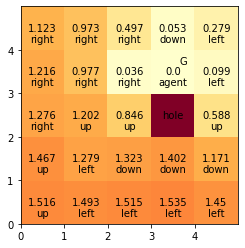

s:(1, 3)　a:up s':(1, 4) a':down
----
s:(1, 4)　a:down s':(1, 3) a':right
----
s:(1, 3)　a:right s':(2, 3) a':right
----
s:(2, 3)　a:right s':(2, 3) a':right
----
s:(2, 3)　a:right s':(3, 3) a':up
----


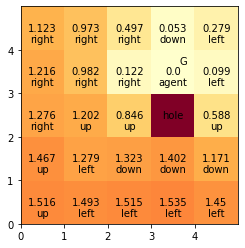

s:(1, 0)　a:right s':(2, 0) a':up
----
s:(2, 0)　a:up s':(2, 1) a':right
----
s:(2, 1)　a:right s':(3, 1) a':left
----
s:(3, 1)　a:left s':(2, 1) a':left
----
s:(2, 1)　a:left s':(1, 1) a':right
----
s:(1, 1)　a:right s':(2, 1) a':down
----
s:(2, 1)　a:down s':(2, 0) a':left
----
s:(2, 0)　a:left s':(1, 0) a':up
----
s:(1, 0)　a:up s':(1, 1) a':down
----
s:(1, 1)　a:down s':(1, 0) a':left
----
s:(1, 0)　a:left s':(0, 0) a':left
----
s:(0, 0)　a:left s':(0, 0) a':left
----
s:(0, 0)　a:left s':(0, 0) a':right
----
s:(0, 0)　a:right s':(1, 0) a':right
----
s:(1, 0)　a:right s':(2, 0) a':up
----
s:(2, 0)　a:up s':(2, 0) a':down
----
s:(2, 0)　a:down s':(2, 0) a':left
----
s:(2, 0)　a:left s':(1, 0) a':up
----
s:(1, 0)　a:up s':(1, 1) a':left
----
s:(1, 1)　a:left s':(0, 1) a':right
----
s:(0, 1)　a:right s':(0, 1) a':right
----
s:(0, 1)　a:right s':(1, 1) a':down
----
s:(1, 1)　a:down s':(1, 0) a':down
----
s:(1, 0)　a:down s':(1, 0) a':down
----
s:(1, 0)　a:down s':(1, 0) a':left
----
s:(1, 0)　a:left s':(0, 0) a'

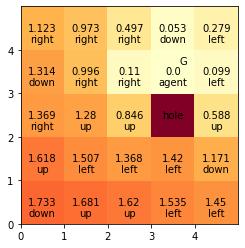

s:(4, 1)　a:right s':(4, 1) a':right
----
s:(4, 1)　a:right s':(4, 1) a':up
----
s:(4, 1)　a:up s':(4, 2) a':right
----
s:(4, 2)　a:right s':(4, 2) a':right
----
s:(4, 2)　a:right s':(4, 2) a':down
----
s:(4, 2)　a:down s':(4, 2) a':up
----
s:(4, 2)　a:up s':(4, 3) a':left
----
s:(4, 3)　a:left s':(3, 3) a':up
----


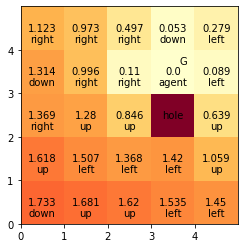

s:(4, 4)　a:right s':(4, 4) a':right
----
s:(4, 4)　a:right s':(4, 4) a':down
----
s:(4, 4)　a:down s':(4, 3) a':left
----
s:(4, 3)　a:left s':(3, 3) a':up
----


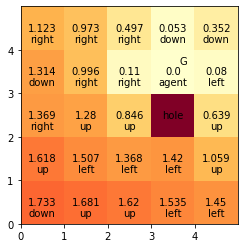

s:(4, 3)　a:left s':(3, 3) a':up
----


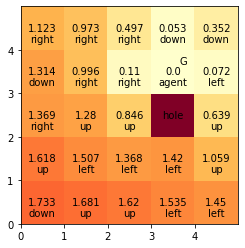

s:(2, 4)　a:down s':(2, 3) a':right
----
s:(2, 3)　a:right s':(2, 3) a':right
----
s:(2, 3)　a:right s':(3, 3) a':up
----


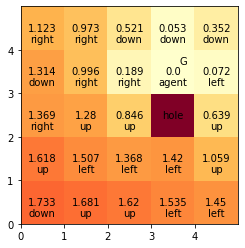

s:(2, 3)　a:right s':(3, 3) a':up
----


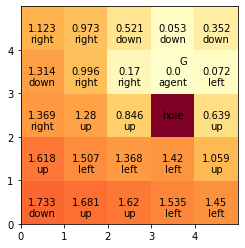

s:(0, 0)　a:up s':(0, 1) a':left
----
s:(0, 1)　a:left s':(0, 1) a':left
----
s:(0, 1)　a:left s':(0, 1) a':right
----
s:(0, 1)　a:right s':(0, 1) a':right
----
s:(0, 1)　a:right s':(1, 1) a':right
----
s:(1, 1)　a:right s':(2, 1) a':up
----
s:(2, 1)　a:up s':(2, 2) a':left
----
s:(2, 2)　a:left s':(1, 2) a':left
----
s:(1, 2)　a:left s':(0, 2) a':up
----
s:(0, 2)　a:up s':(0, 3) a':right
----
s:(0, 3)　a:right s':(1, 3) a':right
----
s:(1, 3)　a:right s':(2, 3) a':right
----
s:(2, 3)　a:right s':(3, 3) a':up
----


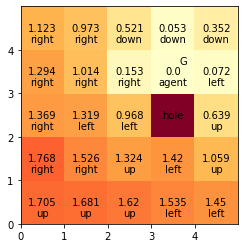

s:(0, 2)　a:right s':(1, 2) a':down
----
s:(1, 2)　a:down s':(1, 1) a':down
----
s:(1, 1)　a:down s':(1, 0) a':right
----
s:(1, 0)　a:right s':(2, 0) a':right
----
s:(2, 0)　a:right s':(3, 0) a':up
----
s:(3, 0)　a:up s':(3, 1) a':right
----
s:(3, 1)　a:right s':(4, 1) a':up
----
s:(4, 1)　a:up s':(4, 2) a':up
----
s:(4, 2)　a:up s':(4, 3) a':left
----
s:(4, 3)　a:left s':(4, 3) a':right
----
s:(4, 3)　a:right s':(4, 3) a':right
----
s:(4, 3)　a:right s':(4, 3) a':left
----
s:(4, 3)　a:left s':(3, 3) a':up
----


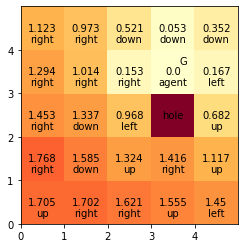

s:(1, 0)　a:up s':(1, 1) a':up
----
s:(1, 1)　a:up s':(1, 2) a':right
----
s:(1, 2)　a:right s':(2, 2) a':up
----
s:(2, 2)　a:up s':(2, 3) a':right
----
s:(2, 3)　a:right s':(3, 3) a':up
----


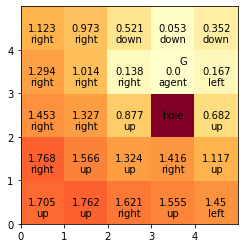

s:(1, 4)　a:up s':(1, 4) a':right
----
s:(1, 4)　a:right s':(2, 4) a':down
----
s:(2, 4)　a:down s':(2, 3) a':right
----
s:(2, 3)　a:right s':(3, 3) a':up
----


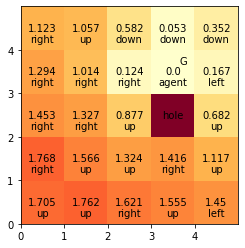

s:(0, 0)　a:up s':(0, 1) a':up
----
s:(0, 1)　a:up s':(0, 1) a':up
----
s:(0, 1)　a:up s':(0, 2) a':down
----
s:(0, 2)　a:down s':(0, 2) a':down
----
s:(0, 2)　a:down s':(0, 2) a':down
----
s:(0, 2)　a:down s':(0, 1) a':down
----
s:(0, 1)　a:down s':(0, 0) a':left
----
s:(0, 0)　a:left s':(0, 0) a':left
----
s:(0, 0)　a:left s':(0, 0) a':right
----
s:(0, 0)　a:right s':(1, 0) a':right
----
s:(1, 0)　a:right s':(2, 0) a':up
----
s:(2, 0)　a:up s':(2, 1) a':up
----
s:(2, 1)　a:up s':(2, 2) a':up
----
s:(2, 2)　a:up s':(2, 2) a':up
----
s:(2, 2)　a:up s':(2, 3) a':right
----
s:(2, 3)　a:right s':(3, 3) a':left
----


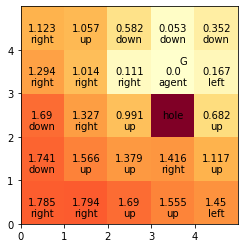

s:(4, 1)　a:up s':(4, 2) a':up
----
s:(4, 2)　a:up s':(4, 2) a':up
----
s:(4, 2)　a:up s':(4, 3) a':left
----
s:(4, 3)　a:left s':(3, 3) a':up
----


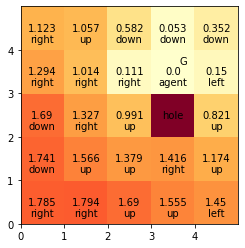

s:(1, 0)　a:down s':(1, 0) a':up
----
s:(1, 0)　a:up s':(1, 1) a':left
----
s:(1, 1)　a:left s':(0, 1) a':down
----
s:(0, 1)　a:down s':(0, 0) a':down
----
s:(0, 0)　a:down s':(0, 0) a':down
----
s:(0, 0)　a:down s':(0, 0) a':right
----
s:(0, 0)　a:right s':(1, 0) a':left
----
s:(1, 0)　a:left s':(0, 0) a':up
----
s:(0, 0)　a:up s':(0, 1) a':left
----
s:(0, 1)　a:left s':(0, 1) a':left
----
s:(0, 1)　a:left s':(0, 1) a':right
----
s:(0, 1)　a:right s':(1, 1) a':right
----
s:(1, 1)　a:right s':(2, 1) a':right
----
s:(2, 1)　a:right s':(3, 1) a':down
----
s:(3, 1)　a:down s':(3, 0) a':left
----
s:(3, 0)　a:left s':(2, 0) a':right
----
s:(2, 0)　a:right s':(2, 0) a':right
----
s:(2, 0)　a:right s':(3, 0) a':right
----
s:(3, 0)　a:right s':(4, 0) a':up
----
s:(4, 0)　a:up s':(4, 1) a':down
----
s:(4, 1)　a:down s':(4, 0) a':down
----
s:(4, 0)　a:down s':(4, 0) a':down
----
s:(4, 0)　a:down s':(4, 0) a':up
----
s:(4, 0)　a:up s':(4, 0) a':up
----
s:(4, 0)　a:up s':(4, 1) a':up
----
s:(4, 1)　a:up s':(4, 2) a':down
-

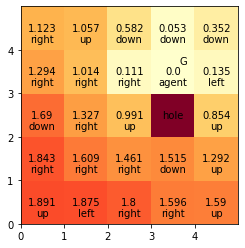

s:(1, 1)　a:up s':(1, 2) a':right
----
s:(1, 2)　a:right s':(2, 2) a':down
----
s:(2, 2)　a:down s':(2, 1) a':left
----
s:(2, 1)　a:left s':(1, 1) a':down
----
s:(1, 1)　a:down s':(1, 0) a':right
----
s:(1, 0)　a:right s':(2, 0) a':down
----
s:(2, 0)　a:down s':(2, 0) a':down
----
s:(2, 0)　a:down s':(2, 0) a':up
----
s:(2, 0)　a:up s':(2, 1) a':up
----
s:(2, 1)　a:up s':(2, 1) a':up
----
s:(2, 1)　a:up s':(2, 2) a':up
----
s:(2, 2)　a:up s':(2, 3) a':right
----
s:(2, 3)　a:right s':(3, 3) a':up
----


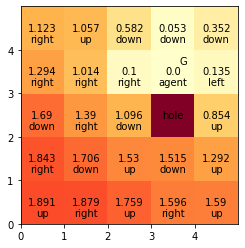

s:(2, 4)　a:right s':(3, 4) a':down
----
s:(3, 4)　a:down s':(3, 3) a':up
----


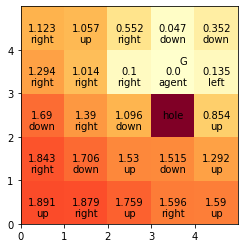

s:(1, 2)　a:up s':(1, 3) a':right
----
s:(1, 3)　a:right s':(2, 3) a':right
----
s:(2, 3)　a:right s':(3, 3) a':down
----


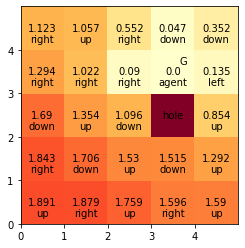

s:(2, 3)　a:right s':(3, 3) a':up
----


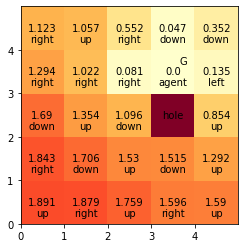

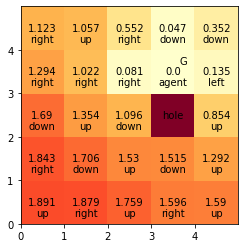

s:(3, 4)　a:down s':(3, 3) a':up
----


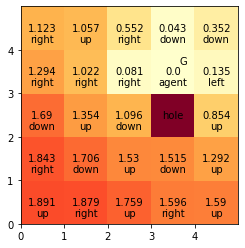

s:(3, 0)　a:down s':(3, 0) a':left
----
s:(3, 0)　a:left s':(3, 0) a':up
----
s:(3, 0)　a:up s':(3, 1) a':right
----
s:(3, 1)　a:right s':(4, 1) a':left
----
s:(4, 1)　a:left s':(3, 1) a':left
----
s:(3, 1)　a:left s':(2, 1) a':down
----
s:(2, 1)　a:down s':(2, 0) a':left
----
s:(2, 0)　a:left s':(1, 0) a':down
----
s:(1, 0)　a:down s':(1, 0) a':down
----
s:(1, 0)　a:down s':(1, 0) a':up
----
s:(1, 0)　a:up s':(1, 1) a':right
----
s:(1, 1)　a:right s':(2, 1) a':left
----
s:(2, 1)　a:left s':(1, 1) a':left
----
s:(1, 1)　a:left s':(1, 1) a':left
----
s:(1, 1)　a:left s':(0, 1) a':down
----
s:(0, 1)　a:down s':(0, 0) a':left
----
s:(0, 0)　a:left s':(0, 0) a':left
----
s:(0, 0)　a:left s':(0, 0) a':right
----
s:(0, 0)　a:right s':(1, 0) a':left
----
s:(1, 0)　a:left s':(0, 0) a':up
----
s:(0, 0)　a:up s':(0, 1) a':up
----
s:(0, 1)　a:up s':(0, 2) a':up
----
s:(0, 2)　a:up s':(0, 3) a':up
----
s:(0, 3)　a:up s':(0, 4) a':left
----
s:(0, 4)　a:left s':(0, 4) a':left
----
s:(0, 4)　a:left s':(0, 4) a':down
----
s:(0

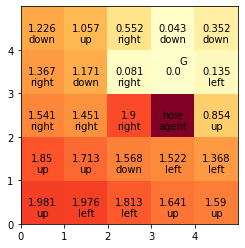

s:(1, 4)　a:right s':(2, 4) a':right
----
s:(2, 4)　a:right s':(3, 4) a':down
----
s:(3, 4)　a:down s':(3, 3) a':up
----


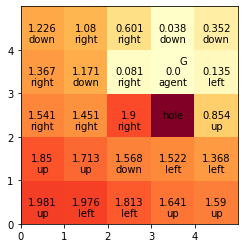

s:(3, 0)　a:right s':(4, 0) a':left
----
s:(4, 0)　a:left s':(3, 0) a':up
----
s:(3, 0)　a:up s':(3, 1) a':right
----
s:(3, 1)　a:right s':(3, 1) a':right
----
s:(3, 1)　a:right s':(4, 1) a':down
----
s:(4, 1)　a:down s':(4, 0) a':right
----
s:(4, 0)　a:right s':(4, 0) a':down
----
s:(4, 0)　a:down s':(4, 0) a':down
----
s:(4, 0)　a:down s':(4, 0) a':left
----
s:(4, 0)　a:left s':(3, 0) a':down
----
s:(3, 0)　a:down s':(3, 0) a':down
----
s:(3, 0)　a:down s':(3, 0) a':right
----
s:(3, 0)　a:right s':(4, 0) a':right
----
s:(4, 0)　a:right s':(4, 0) a':up
----
s:(4, 0)　a:up s':(4, 0) a':up
----
s:(4, 0)　a:up s':(4, 1) a':up
----
s:(4, 1)　a:up s':(4, 2) a':up
----
s:(4, 2)　a:up s':(4, 3) a':left
----
s:(4, 3)　a:left s':(3, 3) a':up
----


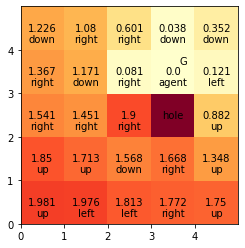

s:(0, 2)　a:down s':(0, 1) a':right
----
s:(0, 1)　a:right s':(1, 1) a':right
----
s:(1, 1)　a:right s':(2, 1) a':right
----
s:(2, 1)　a:right s':(3, 1) a':down
----
s:(3, 1)　a:down s':(3, 0) a':up
----
s:(3, 0)　a:up s':(3, 1) a':left
----
s:(3, 1)　a:left s':(2, 1) a':up
----
s:(2, 1)　a:up s':(2, 2) a':up
----
s:(2, 2)　a:up s':(2, 2) a':up
----
s:(2, 2)　a:up s':(2, 2) a':down
----
s:(2, 2)　a:down s':(2, 1) a':right
----
s:(2, 1)　a:right s':(3, 1) a':right
----
s:(3, 1)　a:right s':(4, 1) a':up
----
s:(4, 1)　a:up s':(4, 2) a':up
----
s:(4, 2)　a:up s':(4, 3) a':left
----
s:(4, 3)　a:left s':(3, 3) a':up
----


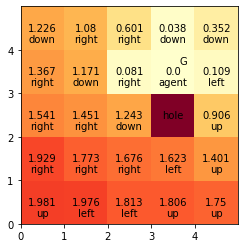

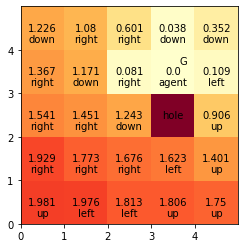

s:(1, 1)　a:down s':(1, 0) a':right
----
s:(1, 0)　a:right s':(2, 0) a':up
----
s:(2, 0)　a:up s':(2, 1) a':down
----
s:(2, 1)　a:down s':(2, 0) a':right
----
s:(2, 0)　a:right s':(3, 0) a':left
----
s:(3, 0)　a:left s':(2, 0) a':left
----
s:(2, 0)　a:left s':(1, 0) a':up
----
s:(1, 0)　a:up s':(1, 1) a':up
----
s:(1, 1)　a:up s':(1, 2) a':up
----
s:(1, 2)　a:up s':(1, 3) a':right
----
s:(1, 3)　a:right s':(2, 3) a':right
----
s:(2, 3)　a:right s':(3, 3) a':up
----


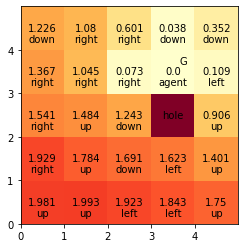

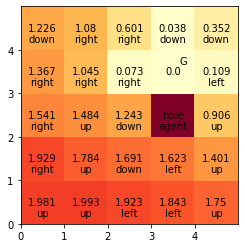

s:(3, 0)　a:right s':(3, 0) a':right
----
s:(3, 0)　a:right s':(4, 0) a':left
----
s:(4, 0)　a:left s':(4, 0) a':left
----
s:(4, 0)　a:left s':(3, 0) a':up
----
s:(3, 0)　a:up s':(3, 1) a':left
----
s:(3, 1)　a:left s':(2, 1) a':up
----
s:(2, 1)　a:up s':(2, 1) a':up
----
s:(2, 1)　a:up s':(2, 2) a':left
----
s:(2, 2)　a:left s':(1, 2) a':left
----
s:(1, 2)　a:left s':(0, 2) a':up
----
s:(0, 2)　a:up s':(0, 3) a':up
----
s:(0, 3)　a:up s':(0, 4) a':right
----
s:(0, 4)　a:right s':(1, 4) a':left
----
s:(1, 4)　a:left s':(0, 4) a':up
----
s:(0, 4)　a:up s':(0, 4) a':up
----
s:(0, 4)　a:up s':(0, 4) a':right
----
s:(0, 4)　a:right s':(1, 4) a':up
----
s:(1, 4)　a:up s':(1, 4) a':up
----
s:(1, 4)　a:up s':(1, 4) a':right
----
s:(1, 4)　a:right s':(2, 4) a':up
----
s:(2, 4)　a:up s':(2, 4) a':right
----
s:(2, 4)　a:right s':(3, 4) a':down
----
s:(3, 4)　a:down s':(3, 4) a':down
----
s:(3, 4)　a:down s':(3, 3) a':up
----


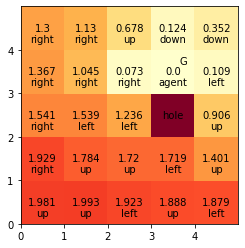

s:(1, 2)　a:down s':(1, 2) a':right
----
s:(1, 2)　a:right s':(2, 2) a':up
----
s:(2, 2)　a:up s':(2, 3) a':down
----
s:(2, 3)　a:down s':(2, 2) a':up
----
s:(2, 2)　a:up s':(2, 3) a':right
----
s:(2, 3)　a:right s':(2, 3) a':right
----
s:(2, 3)　a:right s':(3, 3) a':up
----


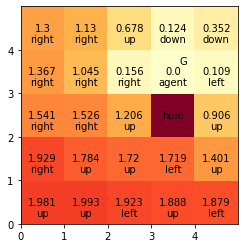

s:(4, 2)　a:up s':(4, 3) a':left
----
s:(4, 3)　a:left s':(4, 3) a':left
----
s:(4, 3)　a:left s':(3, 3) a':up
----


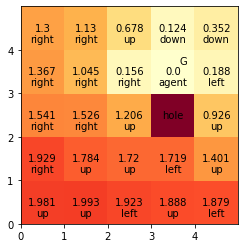

s:(4, 1)　a:left s':(3, 1) a':down
----
s:(3, 1)　a:down s':(3, 0) a':down
----
s:(3, 0)　a:down s':(3, 0) a':down
----
s:(3, 0)　a:down s':(3, 0) a':left
----
s:(3, 0)　a:left s':(2, 0) a':up
----
s:(2, 0)　a:up s':(2, 1) a':left
----
s:(2, 1)　a:left s':(1, 1) a':right
----
s:(1, 1)　a:right s':(1, 1) a':right
----
s:(1, 1)　a:right s':(2, 1) a':down
----
s:(2, 1)　a:down s':(2, 0) a':down
----
s:(2, 0)　a:down s':(2, 0) a':down
----
s:(2, 0)　a:down s':(2, 0) a':right
----
s:(2, 0)　a:right s':(3, 0) a':up
----
s:(3, 0)　a:up s':(3, 1) a':left
----
s:(3, 1)　a:left s':(2, 1) a':right
----
s:(2, 1)　a:right s':(3, 1) a':up
----
s:(3, 1)　a:up s':(3, 2) a':up
----


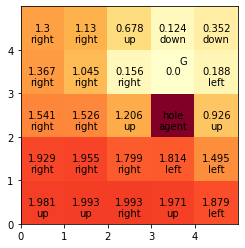

s:(3, 0)　a:left s':(2, 0) a':up
----
s:(2, 0)　a:up s':(2, 1) a':up
----
s:(2, 1)　a:up s':(2, 2) a':up
----
s:(2, 2)　a:up s':(2, 3) a':right
----
s:(2, 3)　a:right s':(2, 3) a':right
----
s:(2, 3)　a:right s':(3, 3) a':up
----


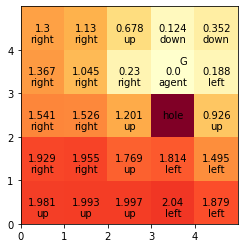

s:(0, 4)　a:down s':(0, 3) a':down
----
s:(0, 3)　a:down s':(0, 2) a':right
----
s:(0, 2)　a:right s':(0, 2) a':left
----
s:(0, 2)　a:left s':(0, 2) a':up
----
s:(0, 2)　a:up s':(0, 3) a':right
----
s:(0, 3)　a:right s':(1, 3) a':right
----
s:(1, 3)　a:right s':(2, 3) a':up
----
s:(2, 3)　a:up s':(2, 4) a':down
----
s:(2, 4)　a:down s':(2, 3) a':right
----
s:(2, 3)　a:right s':(3, 3) a':up
----


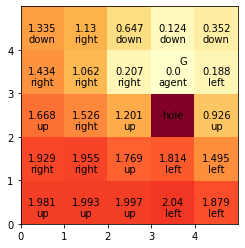

s:(1, 2)　a:up s':(1, 3) a':right
----
s:(1, 3)　a:right s':(2, 3) a':right
----
s:(2, 3)　a:right s':(3, 3) a':up
----


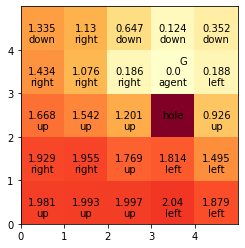

s:(3, 1)　a:right s':(4, 1) a':right
----
s:(4, 1)　a:right s':(4, 1) a':left
----
s:(4, 1)　a:left s':(3, 1) a':down
----
s:(3, 1)　a:down s':(3, 0) a':right
----
s:(3, 0)　a:right s':(4, 0) a':right
----
s:(4, 0)　a:right s':(4, 0) a':right
----
s:(4, 0)　a:right s':(4, 0) a':down
----
s:(4, 0)　a:down s':(4, 0) a':down
----
s:(4, 0)　a:down s':(4, 0) a':up
----
s:(4, 0)　a:up s':(4, 1) a':up
----
s:(4, 1)　a:up s':(4, 1) a':up
----
s:(4, 1)　a:up s':(4, 2) a':up
----
s:(4, 2)　a:up s':(4, 3) a':left
----
s:(4, 3)　a:left s':(3, 3) a':right
----


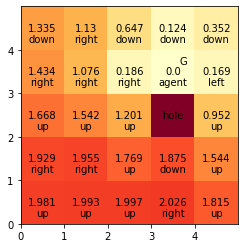

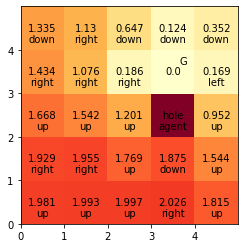

s:(2, 1)　a:left s':(1, 1) a':up
----
s:(1, 1)　a:up s':(1, 1) a':up
----
s:(1, 1)　a:up s':(1, 2) a':right
----
s:(1, 2)　a:right s':(2, 2) a':up
----
s:(2, 2)　a:up s':(2, 2) a':up
----
s:(2, 2)　a:up s':(2, 3) a':right
----
s:(2, 3)　a:right s':(3, 3) a':up
----


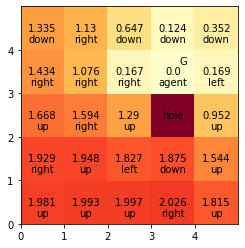

s:(1, 0)　a:right s':(2, 0) a':left
----
s:(2, 0)　a:left s':(1, 0) a':left
----
s:(1, 0)　a:left s':(0, 0) a':down
----
s:(0, 0)　a:down s':(0, 0) a':down
----
s:(0, 0)　a:down s':(0, 0) a':up
----
s:(0, 0)　a:up s':(0, 1) a':up
----
s:(0, 1)　a:up s':(0, 2) a':right
----
s:(0, 2)　a:right s':(1, 2) a':left
----
s:(1, 2)　a:left s':(1, 2) a':left
----
s:(1, 2)　a:left s':(0, 2) a':right
----
s:(0, 2)　a:right s':(1, 2) a':up
----
s:(1, 2)　a:up s':(1, 3) a':left
----
s:(1, 3)　a:left s':(0, 3) a':up
----
s:(0, 3)　a:up s':(0, 4) a':right
----
s:(0, 4)　a:right s':(1, 4) a':down
----
s:(1, 4)　a:down s':(1, 3) a':up
----
s:(1, 3)　a:up s':(1, 4) a':up
----
s:(1, 4)　a:up s':(1, 4) a':right
----
s:(1, 4)　a:right s':(2, 4) a':left
----
s:(2, 4)　a:left s':(1, 4) a':left
----
s:(1, 4)　a:left s':(0, 4) a':left
----
s:(0, 4)　a:left s':(0, 4) a':left
----
s:(0, 4)　a:left s':(0, 4) a':left
----
s:(0, 4)　a:left s':(0, 4) a':down
----
s:(0, 4)　a:down s':(0, 3) a':up
----
s:(0, 3)　a:up s':(0, 4) a':left
----
s:(0,

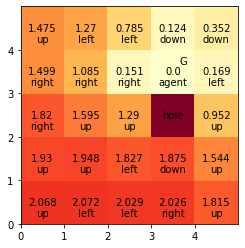

s:(0, 0)　a:right s':(1, 0) a':up
----
s:(1, 0)　a:up s':(1, 1) a':down
----
s:(1, 1)　a:down s':(1, 0) a':down
----
s:(1, 0)　a:down s':(1, 0) a':down
----
s:(1, 0)　a:down s':(1, 0) a':right
----
s:(1, 0)　a:right s':(2, 0) a':right
----
s:(2, 0)　a:right s':(3, 0) a':left
----
s:(3, 0)　a:left s':(2, 0) a':up
----
s:(2, 0)　a:up s':(2, 1) a':up
----
s:(2, 1)　a:up s':(2, 2) a':left
----
s:(2, 2)　a:left s':(1, 2) a':down
----
s:(1, 2)　a:down s':(1, 1) a':left
----
s:(1, 1)　a:left s':(0, 1) a':right
----
s:(0, 1)　a:right s':(1, 1) a':down
----
s:(1, 1)　a:down s':(1, 0) a':left
----
s:(1, 0)　a:left s':(0, 0) a':right
----
s:(0, 0)　a:right s':(1, 0) a':up
----
s:(1, 0)　a:up s':(1, 1) a':up
----
s:(1, 1)　a:up s':(1, 2) a':down
----
s:(1, 2)　a:down s':(1, 1) a':left
----
s:(1, 1)　a:left s':(1, 1) a':left
----
s:(1, 1)　a:left s':(0, 1) a':up
----
s:(0, 1)　a:up s':(0, 2) a':up
----
s:(0, 2)　a:up s':(0, 3) a':down
----
s:(0, 3)　a:down s':(0, 2) a':left
----
s:(0, 2)　a:left s':(0, 2) a':right
----
s:(0

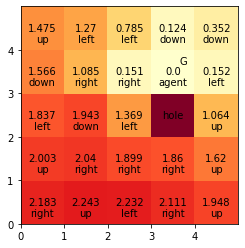

s:(0, 3)　a:left s':(0, 3) a':left
----
s:(0, 3)　a:left s':(0, 3) a':right
----
s:(0, 3)　a:right s':(1, 3) a':right
----
s:(1, 3)　a:right s':(2, 3) a':right
----
s:(2, 3)　a:right s':(2, 3) a':right
----
s:(2, 3)　a:right s':(3, 3) a':up
----


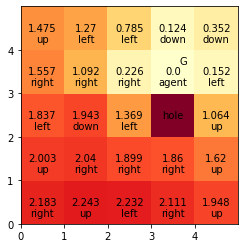

s:(3, 0)　a:up s':(3, 1) a':left
----
s:(3, 1)　a:left s':(2, 1) a':down
----
s:(2, 1)　a:down s':(2, 0) a':down
----
s:(2, 0)　a:down s':(2, 0) a':down
----
s:(2, 0)　a:down s':(2, 0) a':up
----
s:(2, 0)　a:up s':(2, 1) a':up
----
s:(2, 1)　a:up s':(2, 2) a':down
----
s:(2, 2)　a:down s':(2, 1) a':left
----
s:(2, 1)　a:left s':(1, 1) a':up
----
s:(1, 1)　a:up s':(1, 2) a':right
----
s:(1, 2)　a:right s':(2, 2) a':up
----
s:(2, 2)　a:up s':(2, 3) a':right
----
s:(2, 3)　a:right s':(3, 3) a':up
----


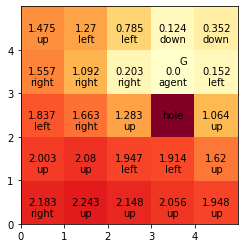

s:(2, 3)　a:down s':(2, 2) a':up
----
s:(2, 2)　a:up s':(2, 3) a':right
----
s:(2, 3)　a:right s':(3, 3) a':up
----


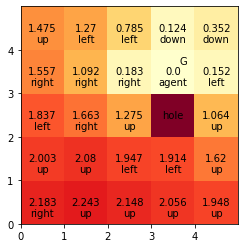

s:(3, 0)　a:down s':(3, 0) a':down
----
s:(3, 0)　a:down s':(3, 0) a':up
----
s:(3, 0)　a:up s':(3, 1) a':up
----
s:(3, 1)　a:up s':(3, 2) a':up
----


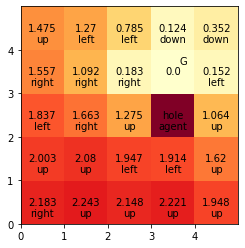

s:(1, 3)　a:right s':(2, 3) a':right
----
s:(2, 3)　a:right s':(3, 3) a':up
----


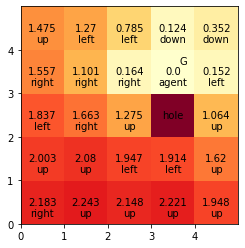

s:(1, 3)　a:right s':(1, 3) a':right
----
s:(1, 3)　a:right s':(1, 3) a':down
----
s:(1, 3)　a:down s':(1, 2) a':up
----
s:(1, 2)　a:up s':(1, 3) a':up
----
s:(1, 3)　a:up s':(1, 4) a':right
----
s:(1, 4)　a:right s':(2, 4) a':right
----
s:(2, 4)　a:right s':(3, 4) a':right
----
s:(3, 4)　a:right s':(3, 4) a':right
----
s:(3, 4)　a:right s':(3, 4) a':left
----
s:(3, 4)　a:left s':(2, 4) a':down
----
s:(2, 4)　a:down s':(2, 3) a':right
----
s:(2, 3)　a:right s':(3, 3) a':up
----


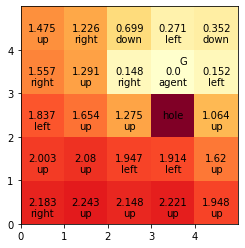

In [48]:
alpha = 0.1
gamma = 1.0

def sarsa(s_pos,a):
    s = states[s_pos[0]][s_pos[1]]
    s_next_pos = state_transition(s_pos,a)
    s_next = states[s_next_pos[0]][s_next_pos[1]]
    a_next = e_greedy(s_next)
    
    #reward = 1.0
    #q = (1.0 - alpha) * s.Q[a] + alpha * (reward + gamma * s_next.Q[a_next])
    print("s:" + str(s_pos)+ "　a:" + a + " s':" + str(s_next_pos) + " a':" + a_next)
    print("----")
    return s_next_pos, a_next

def sarsa_update(s_pos, a, reward, s_next, a_next):
    s = states[s_pos[0]][s_pos[1]]
    q = (1.0 - alpha) * s.Q[a] + alpha * (reward + gamma * s_next.Q[a_next])
    return q

def one_trial():
    agent.pos = (random.randrange(size),random.randrange(size))
    a = e_greedy(states[agent.pos[0]][agent.pos[1]])
    if states[agent.pos[0]][agent.pos[1]].goal or states[agent.pos[0]][agent.pos[1]].obstacle:
        return
          
    while True:
        #draw(None)
        s_next, a_next = sarsa(agent.pos ,a)
        reward = 1.0
        if states[s_next[0]][s_next[1]].obstacle:
            reward = 10.0
        if states[s_next[0]][s_next[1]].goal:
            reward = 0.0
        q = sarsa_update(agent.pos, a, reward, states[s_next[0]][s_next[1]], a_next)
        states[agent.pos[0]][agent.pos[1]].Q[a] = q
        agent.pos = s_next
        a = a_next
        if states[agent.pos[0]][agent.pos[1]].goal or states[agent.pos[0]][agent.pos[1]].obstacle:
            break
        

for i in range(100):
    one_trial()
    draw("all")